Claire Phillips

1010781566

https://colab.research.google.com/drive/1G_F_vwVKJyIcx08qAMFuKi_Hxtyyysw2?usp=sharing

In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import f1_score
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [24]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('indian_liver_patient.csv').fillna(0) #reading data and filling null values with 0
# Turning Male/Female into a binary signal.

one_hot = pd.get_dummies(data['Gender'])
data[['Female','Drop']]= one_hot # one column for male and 1 column for female
data = data.drop(['Gender','Drop'],axis=1) # we can drop the original gender column and "drop" which is basically the male column (the exact inverse of female)
data = data.rename(columns={"Female": "Gender"}, errors="raise") #remane Female to Gender
data['Dataset']= data['Dataset']-1. #this metric is either 1 or 2 but we need it to be 0 or 1

#training data
train = data.drop(['Dataset'],axis=1)


In [ ]:
data['Dataset'].sum()/data['Dataset'].count()
#the data set is unbalanced

0.2864493996569468

In [ ]:
scaler = StandardScaler()
normalizer = Normalizer()
train_norm = pd.DataFrame(scaler.fit_transform(train.values), columns=train.columns, index=train.index)
train_norm_scale = pd.DataFrame(normalizer.fit_transform(train_norm.T.values).T, columns=train_norm.columns, index=train_norm.index)
# normalizer normalizes across the row.  we need to transpose then normalize then transpose again!

# Part 3

In [ ]:
train.corr()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender
Age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.203418,-0.056560
Total_Bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.192539,-0.089291
Direct_Bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.186023,-0.100436
Alkaline_Phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.217864,0.027496
Alamine_Aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,0.004184,-0.082332
Aspartate_Aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.062993,-0.080336
Total_Protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.223185,0.089121
Albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.654450,0.093799
Albumin_and_Globulin_Ratio,-0.203418,-0.192539,-0.186023,-0.217864,0.004184,-0.062993,0.223185,0.654450,1.000000,-0.008541
Gender,-0.056560,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,-0.008541,1.000000


In [ ]:
train.corr().abs().min()
min_corr_index_1 = train.corr().abs().min().idxmin()
min_corr_index_2 = train.corr().abs().idxmin()[min_corr_index_1]
min_corr = train.corr()[min_corr_index_1][min_corr_index_2]

In [ ]:
print("min correlation between {0} and {1} with correlation of {2}".format(min_corr_index_1,min_corr_index_2,min_corr))

min correlation between Direct_Bilirubin and Total_Protiens with correlation of -0.00013874142426106262


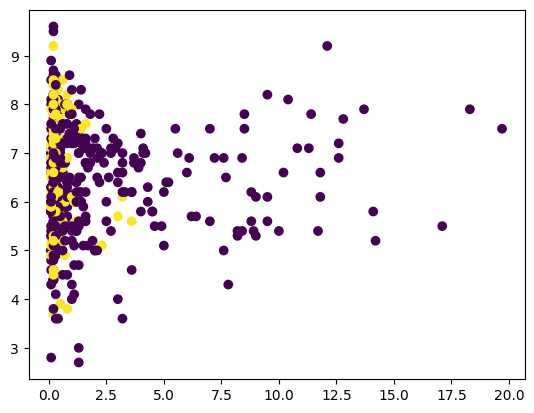

In [ ]:
plt.scatter(train[min_corr_index_1], train[min_corr_index_2], c=data['Dataset'])

The first class is along the y axis while the second class is more spread out. However, without the colours the clusters are much less obvious.

# Part 4

## Kmeans Clustering
  
> K means clustering aims to partition data into k clusters where data points are in the cluster with the closest centeriod (or mean) to given data point. The algorithm beings with dropping k means arbitrariliy over the set and iteratively moving the centeroid to be minimize the within-cluster variances all the sample data points to thier clusters centeroid.

Advantages
> K means clustering guarentees convergence, scales well to large data sets and generalizes to clusters of varying shapes.

Disadvantages
> K means clustering does not handle outliers well.  within cluster variance is the squared euclidean distance of a point for the centeroid.  Outliers will likely have a much larger distance than a non-outlier, and with the distance being squared this has a disporportionately large impact on the model.

---

## Hierarchical Clustering

> Bottom up Hierarchical cluster works by defining each data point as a its own cluster.  Hierarchical clustering then joins clusters together in a heirarchical order until only k clusters remain.  Hierarchical cluster joins clusters togetehr based on linkage distance of the cluster center to the other cluster center.

Advantages
>It is scalable and often has better accuracy than other clustering methods.

Disadvantages
> It is hard to interpret and sensitive to outliers.

In [ ]:
def model_accuracy(predicted_labels, labels):
  accuracy = accuracy_score(labels.to_numpy(), predicted_labels,normalize=True, sample_weight=None)
  if (accuracy < 0.5)&(len(list(set(predicted_labels)))==2):
    predicted_labels = np.array([(1 if xi == 0 else 0) for xi in predicted_labels])
    accuracy = accuracy_score(labels.to_numpy(), predicted_labels,normalize=True, sample_weight=None)
  cm = confusion_matrix(labels,predicted_labels)
  fig = sns.heatmap(cm[:2], annot=True)
  fig.set(xlabel='clusters', ylabel='labels')
  plt.show()
  return accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


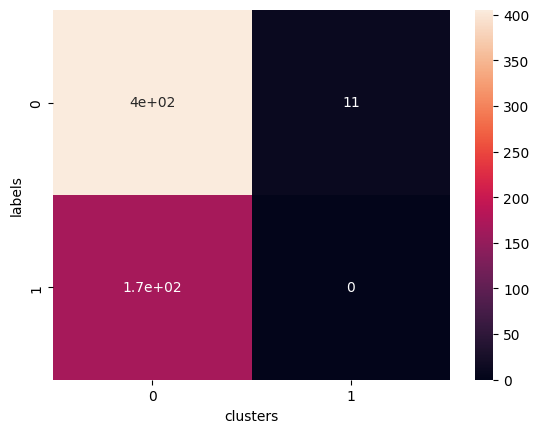

0.6946826758147513

In [ ]:
k_means = KMeans(n_clusters=2)
k_means_train = k_means.fit(train)
predicted_labels=k_means_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

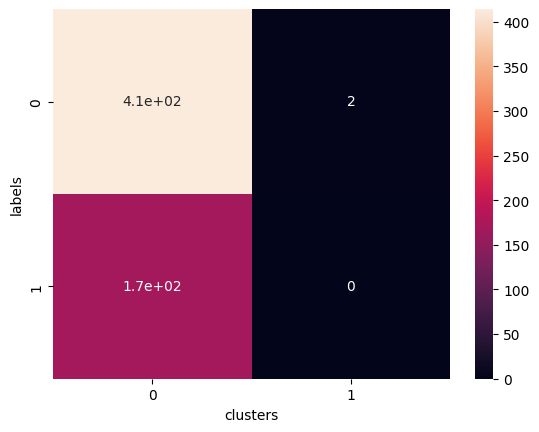

0.7101200686106347

In [ ]:
ac = AgglomerativeClustering(n_clusters=2)
ac_train = ac.fit(train)
predicted_labels=ac_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

Its very interesting how the models seem to only be predicting one class. I'm going to try using normalized and scaled data along with balanced data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


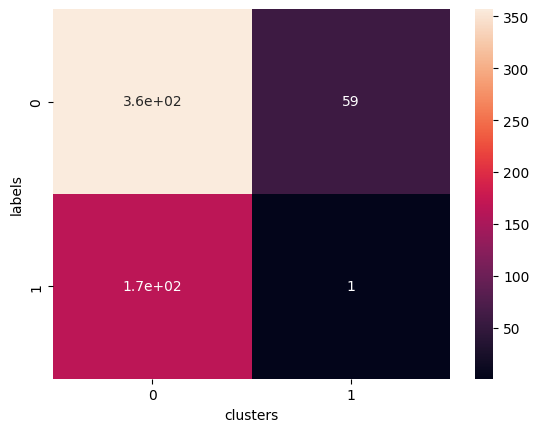

0.614065180102916

In [ ]:
k_means = KMeans(n_clusters=2)
k_means_train = k_means.fit(train_norm_scale)
predicted_labels=k_means_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

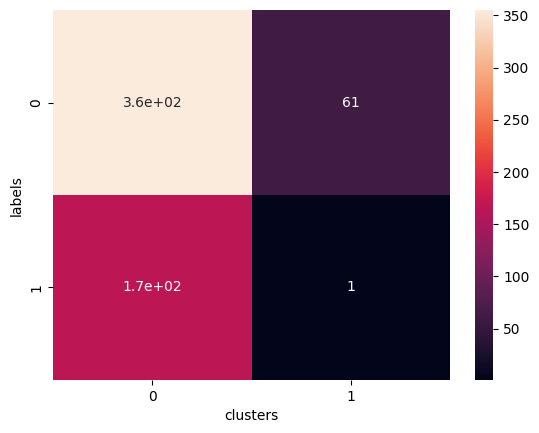

0.6106346483704974

In [ ]:

ac = AgglomerativeClustering(n_clusters=2)
ac_train = ac.fit(train_norm_scale)
predicted_labels=ac_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

c. Repeat the same experiment with different hyperparameters, specifically the
number of clusters.

Finding best k value for k-means.

I attempt using the siloutte for the orignal data and the scaled and normalized data. The highest siloutte is the best.

In [ ]:
def k_iterate(Model,train,ks):
  silhouette = []
  for x in range(2,ks):
    model = Model(n_clusters=x)
    model_train = model.fit(train)
    predicted_labels=model_train.labels_
    silhouette.append(metrics.silhouette_score(train, predicted_labels))
  plt.plot(range(2,ks), silhouette, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('silhouette')
  plt.title('silhouette')
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

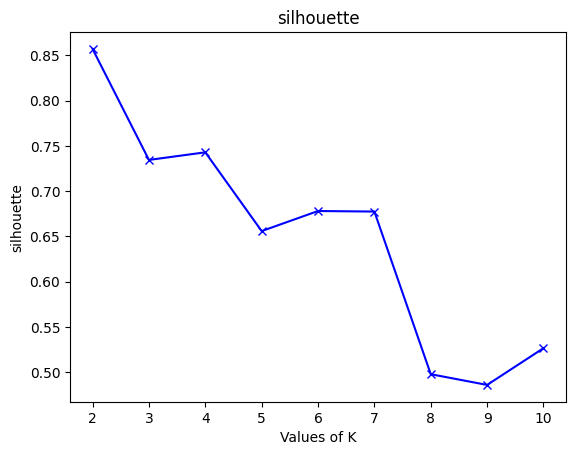

In [ ]:
k_iterate(KMeans,train,11)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

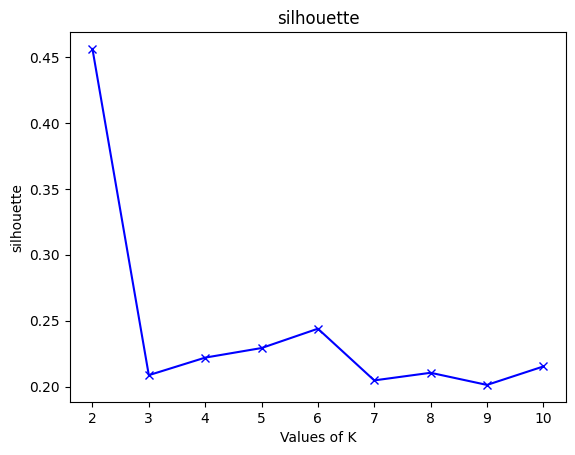

In [ ]:
k_iterate(KMeans,train_norm_scale,11)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


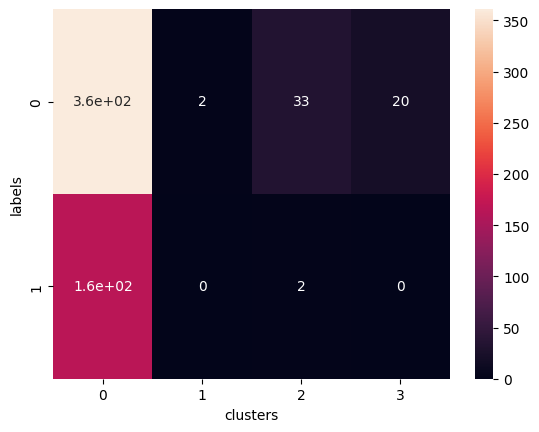

0.6192109777015438

In [ ]:
k_means = KMeans(n_clusters=4)
k_means_train = k_means.fit(train)
predicted_labels=k_means_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

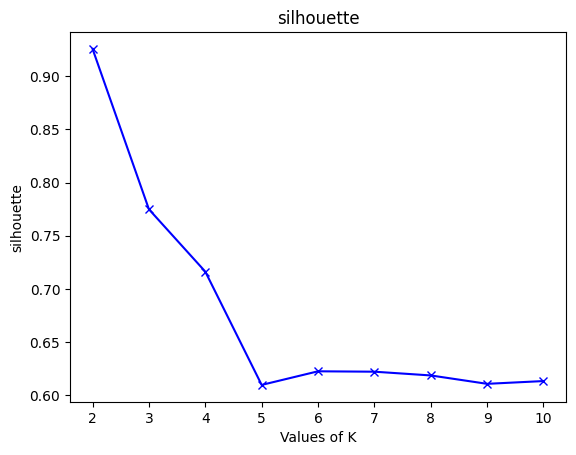

In [ ]:
k_iterate(AgglomerativeClustering,train,11)

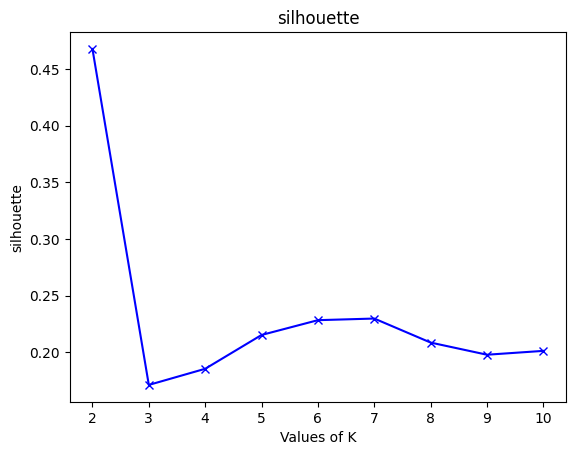

In [ ]:
k_iterate(AgglomerativeClustering,train_norm_scale,11)

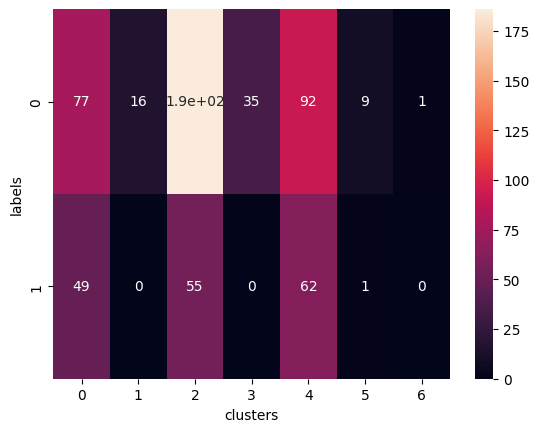

0.1320754716981132

In [ ]:
ac = AgglomerativeClustering(n_clusters=7)
ac_train = ac.fit(train_norm_scale)
predicted_labels=ac_train.labels_
model_accuracy(predicted_labels,data['Dataset'])

Even with the "ideal" number of clusters the method seems to be grouping the data into into one large cluster for the unscaled data.  For the scaled and normalized data the clusters are different across the known labels but the clusters can not clearly be split into the two label categories.

The Agglomerative clustering model with 2 classes does the best job of seperating some elements from class 1 and class 2. It still does not do a great job though.

d. Report which number of clusters is the best to cluster these data? Does this
number match the number of labels you have? Do you observe any subgroups
within a single label?

The idea number of k is 10 for the KMeans Clustering model and 4 for the Agglomerative Clustering model according to the siloutte average value method for clustering. This does not match the number of labels we have.



# Part 5

a. Write a short paragraph about the two methods mentioned above, and discuss the advantages, disadvantages, and use cases for each.

Principal Component Analysis
> PCA works by linearly transforming the data to a new, real coordinate system.  The first new coordinate axis is chosen to have the greatest variance by a scalar projection of the data on the axis.  The datas values on the new axis are the projection of their values on the new axis.  The second axis is then found the same way, the the components from the fist coordinate axis removed from the data.  The third is also found the same way and so on.  If the initial data is n dimensional, then up to n principal components can be found (provided there are > n samples).

Advantages
>  PCA can improve performance for minor losses in accuracy. PAC help with noise reduction in the data, feature selection, and it creates independent, uncorrelated features.

Disadvantages
> PCA makes the data and models designed on PCA much less explainable, which stakeholders often do not like.  PCA loses some information when creating the PCA components.

t-Distributed Stochastic Neighbor Embedding (t-SNE)
> t-SNE first measures the similarity of all data points with each other in n dimensional space using a gaussian kernel (closer together has higher probability of being picked together). Then the algorithm maps the higher diemsional data points onto a lower dimesnional space (2d in this case) while perserving the similarities. The algorithm attempts to minimize the divergence between the probability distribution using gradient descent.

Advantages
>t-SNE is able to preserve local structure.

Disadvantages
> t-SNE has a complexity of over O(n) so it takses longer the more data points are added to the set. The model is non deterministic so you can have different results with the same hyperparameters.



b. Using Sklearn modules, reduce the dimensionality of the data from 10 features
into two features using both methods.

c. Repeat the scatter plot using the reduced features from each method. Unlike the previous
scatter plot, you need to use the labels to have separate colors for each label.

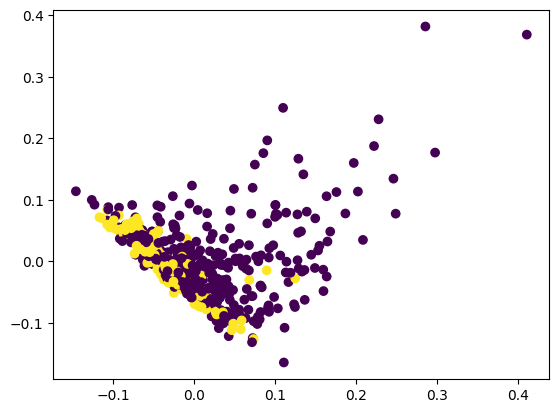

In [ ]:
pca = PCA(n_components=2)
pca2 = pd.DataFrame(pca.fit_transform(train_norm_scale))
plt.scatter(pca2[0], pca2[1], c=data['Dataset'])

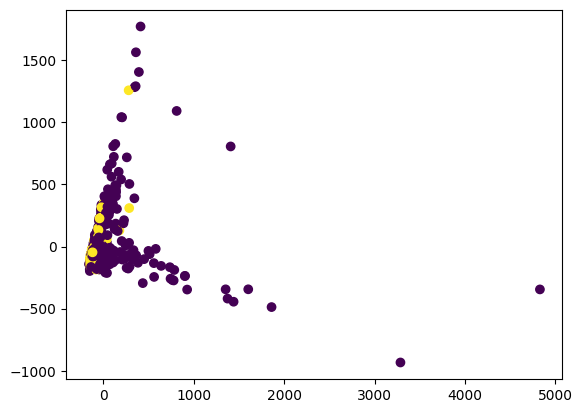

In [ ]:
pca = PCA(n_components=2)
pca2 = pd.DataFrame(pca.fit_transform(train))
plt.scatter(pca2[0], pca2[1], c=data['Dataset'])

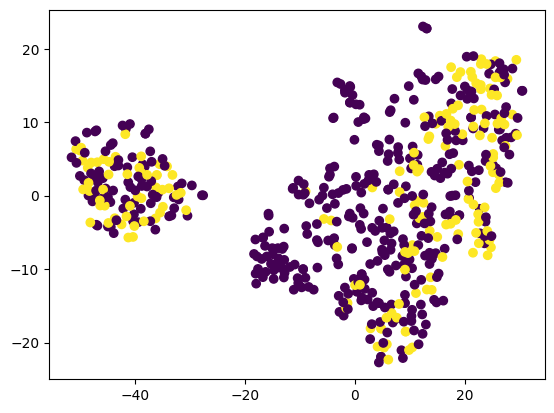

In [ ]:
tsne = TSNE(n_components=2)
tsne2 = pd.DataFrame(tsne.fit_transform(train_norm_scale))
plt.scatter(tsne2[0], tsne2[1], c=data['Dataset'])

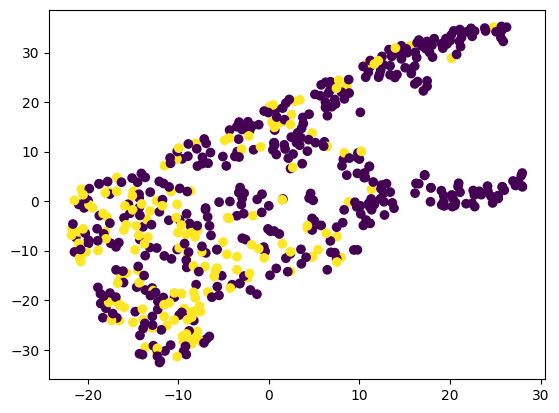

In [ ]:
tsne = TSNE(n_components=2)
tsne2 = pd.DataFrame(tsne.fit_transform(train))
plt.scatter(tsne2[0], tsne2[1], c=data['Dataset'])

d. Compare the output of both method? Which is visually more effective in reducing the
data while preserving the categorization? why?


The first method (PCA) looks similar to the scatter plot created of the two least correlated features, but rotated.  This makes sense because the first 2 axis of PCA are the two least correlated components of the data in 10 dimensional space. The class 1 data is largely on one side of the data while the class 2 data is largely on the other.

The second methods appears to have made two clusters in the normalized ans scaled data.  The un scaled and normalized data appears to be splitable into at most 7 distict clusters. Some clusters hold only class 2 data while others hold much more class 1 data.  

The second method appears better at reducing the data while preserving the categorization because of the clusters formed.

In [27]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [33]:
!jupyter nbconvert --to pdf 'Colab Notebooks/Intro_To_AI_A3.ipynb'

[NbConvertApp] Converting notebook Colab Notebooks/Intro_To_AI_A3.ipynb to pdf
[NbConvertApp] Support files will be in Intro_To_AI_A3_files/
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Making directory ./Intro_To_AI_A3_files
[NbConvertApp] Writing 97722 bytes